# Condition based breakpoints

## Build simple agent

In [17]:
# Import libraries
from langgraph.graph import StateGraph, START, END
from langgraph.errors import NodeInterrupt
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import display, Image
from typing_extensions import TypedDict


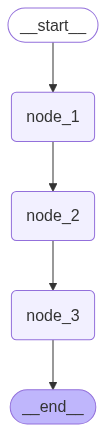

In [18]:
# Build agent

# Define state
class State(TypedDict):
    key: str
    val: str

# Define nodes
def node_1(state: State) -> State:
    print("-- Node 1 --")
    state["val"] = "Working"
    return state

def node_2(state: State) -> State:
    if len(state['key']) > 5:
        raise NodeInterrupt(f"received input that is longer than 5 characters: {state["key"]}")
    print("-- Node 2 --")
    return state

def node_3(state: State) -> State:
    print("-- Node 3 --")
    return state

# Build graph
memory = MemorySaver()
graphBuilder = StateGraph(State)
graphBuilder.add_node("node_1", node_1)
graphBuilder.add_node("node_2", node_2)
graphBuilder.add_node("node_3", node_3)
graphBuilder.add_edge(START, "node_1")
graphBuilder.add_edge("node_1", "node_2")
graphBuilder.add_edge("node_2", "node_3")
graphBuilder.add_edge("node_3", END)

graph = graphBuilder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

## Test the Interrupt

In [24]:
# Trigger test
config = {"configurable": {"thread_id": 1}}
initial_input = {"key": "Hello world!", "val": "init"}

for event in graph.stream(initial_input, config, stream_mode="values"):
    print(event)
    print("*" * 30)

{'key': 'Hello world!', 'val': 'init'}
******************************
-- Node 1 --
{'key': 'Hello world!', 'val': 'Working'}
******************************
{'__interrupt__': (Interrupt(value='received input that is longer than 5 characters: Hello world!', resumable=False, ns=None),)}
******************************


In [25]:
# Get state and display next node
current_state = graph.get_state(config)
print(f"Next node: {current_state.next}")
print(f"Interrupt trace: {current_state.tasks}")

Next node: ('node_2',)
Interrupt trace: (PregelTask(id='3a5b9bb7-1ec1-3e30-e8e3-3e2620f302ea', name='node_2', path=('__pregel_pull', 'node_2'), error=None, interrupts=(Interrupt(value='received input that is longer than 5 characters: Hello world!', resumable=False, ns=None),), state=None, result=None),)


In [26]:
# Attempt to move on from the interrupt
for event in graph.stream(None, config, stream_mode="values"):
    print(event)
    print("*" * 30)

{'key': 'Hello world!', 'val': 'Working'}
******************************
{'__interrupt__': (Interrupt(value='received input that is longer than 5 characters: Hello world!', resumable=False, ns=None),)}
******************************


In [27]:
# Update state to remove error
graph.update_state(config, {"key": "Hi!"})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f03b4c9-344e-68a2-8008-031d059c9a10'}}

In [28]:
# Attempt to move on from the interrupt
for event in graph.stream(None, config, stream_mode="values"):
    print(event)
    print("*" * 30)

{'key': 'Hi!', 'val': 'Working'}
******************************
-- Node 2 --
{'key': 'Hi!', 'val': 'Working'}
******************************
-- Node 3 --
{'key': 'Hi!', 'val': 'Working'}
******************************
